**KMeans Clustering on Twitter :** Alberto Arostegui, David Elorza Gabilondo, Unai Bermúdez -> 06/10/2023

**Descripción:**  ...

**Importar los datos**
Vamos a usar la libreria de pandas para importar los datos del csv y convertirlos en un data frame con el que podamos trabajar.

In [1]:
import pandas as pd
import numpy as np

# the dataset have already been split into train, test set
train  = pd.read_csv("suicidal_data.csv",sep=",", encoding='cp1252')

In [2]:
# Mapear los valores en la columna 'label'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9206 entries, 0 to 9205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9206 non-null   int64 
 1   tweet   9206 non-null   object
dtypes: int64(1), object(1)
memory usage: 144.0+ KB


In [3]:
#Para hacernos una idea son los mensajes en función de la clase:
train[(train['label']==0)].head(5)

,label,tweet
3325,0,i wish i got to watch it with you i miss you ...
3326,0,i want to go to promote gear and groove but u...
3327,0,oh manwas ironing fave top to wear to a meetin...
3328,0,sadly though i ve never gotten to experience t...
3329,0,wonders why someone that u like so much can ma...


In [4]:
train[(train['label']==1)].head(5)

,label,tweet
0,1,my life is meaningless i just want to end my l...
1,1,muttering i wanna die to myself daily for a fe...
2,1,work slave i really feel like my only purpose ...
3,1,i did something on the 2 of october i overdose...
4,1,i feel like no one cares i just want to die ma...


**Análisis de Datos  :** Para hacernos una idea de como es el conjunto de datos vamos a tratar de ver cuantas instancias hay por clase con gráficos, si hay valores faltantes...

In [5]:
print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


Text(0.5, 1.0, 'Barplot del conjunto train')

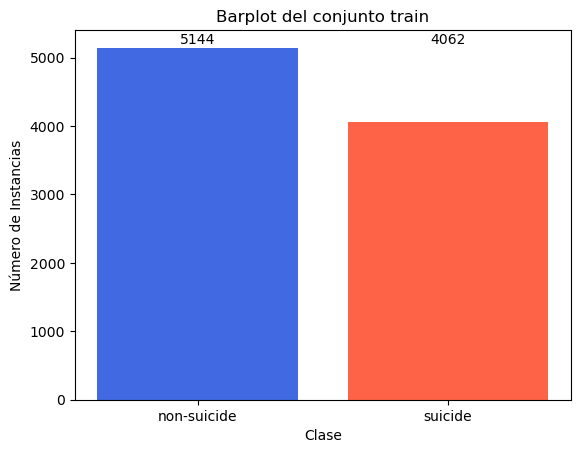

In [17]:
#Si queremos hacernos una idea de cuantas instancias hay por clase, podemos graficarlo mediante este barplot, mediante la libería matplotlib:
import matplotlib.pyplot as plt
# Reemplazar valores de las clases 0 y 1 por etiquetas deseadas
y_train = train['label'].replace({0: 'non-suicide', 1: 'suicide'})

# Contar las instancias por clase
value_counts = y_train.value_counts()
sorted_counts = value_counts.sort_index(ascending=True)
sorted_labels = sorted_counts.index
max_count = sorted_counts.max()

# Colores para las clases
colors = ['royalblue', 'tomato']

# Crear el gráfico de barras con colores
plt.bar(sorted_labels, sorted_counts, color=colors)
label_height = max_count + 10

for index, value in enumerate(sorted_counts):
    plt.text(index, label_height, str(value), ha='center', va='bottom')

plt.xticks(range(len(sorted_labels)), sorted_labels)
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.title('Barplot del conjunto train')

In [18]:
print("Las instancias están repartidas en las dos clases de la siguiente forma:")
print(train['label'].value_counts(), end="\n")

Las instancias están repartidas en las dos clases de la siguiente forma:
label
0    5144
1    4062
Name: count, dtype: int64
0       1
1       1
2       1
3       1
4       1
       ..
9201    1
9202    0
9203    0
9204    0
9205    1
Name: label, Length: 9206, dtype: int64


Para ver cuantos valores faltantes tenemos

In [8]:
# Check for missing values in the DataFrame
missing_values = train.isnull().sum()

# Display the number of missing values for each column
print("Missing Values in the DataFrame:")
print(missing_values)

Missing Values in the DataFrame:
label    0
tweet    0
dtype: int64


Si queremos a ver si hay instancias repetidas:

In [9]:
# Check for duplicated instances
duplicated_instances = train.duplicated().sum()
print("Instancias duplicadas:", duplicated_instances)

Instancias duplicadas: 327


Rango de atributos:

In [10]:
# Range of values for each attribute
attribute_ranges = train.describe()
print("Rango de valores de los atributos:")
print(attribute_ranges)

Rango de valores de los atributos:
             label
count  9206.000000
mean      0.441234
std       0.496562
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


****Preproceso :**** Para que los tweets tengan la información más relevante vamos a aplicar un preproceso de tal forma que se quiten signos de puntuación, mayúsuculas, stopwords y vamos a lematizar las palabras para que nos den toda la misma información.

In [11]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


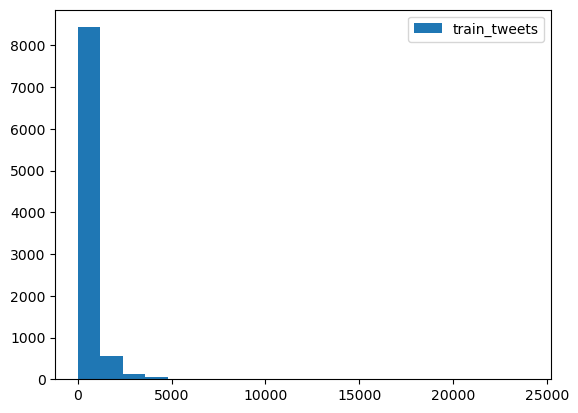

In [12]:
length_train = train['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.legend()
plt.show()

* Se van a quitar los @ de usuario:

In [14]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")
print(type(train['tidy_tweet']))

<class 'pandas.core.series.Series'>


* Se van a remplazar mayúsuclas por minúsculas:

In [14]:
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

* Se juntas las palabras separadas

In [15]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

* Tokenizacion

In [21]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [my, life, is, meaningless, i, just, want, to,...
1    [muttering, i, wanna, die, to, myself, daily, ...
2    [work, slave, i, really, feel, like, my, only,...
3    [i, did, something, on, the, 2, of, october, i...
4    [i, feel, like, no, one, cares, i, just, want,...
Name: tidy_tweet, dtype: object

* Se stematizan las palabras

In [17]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

train['tidy_tweet'] = tokenized_tweet

* Se borran las stopwords

In [18]:
import nltk.corpus

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['fuck', 'shit'])

In [19]:
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: remove_stopwords(x)) # stemming
# combi.head()

* Y con esto obtenemos ya los tweets preprocesados:

In [20]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

#visualize all the words our data using the wordcloud plot
all_words = ' '.join([text for text in train['tidy_tweet']])

** Palabras representtivas **

* Con esto podemos observar las palabras que más se repiten en general en los tweets:

C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


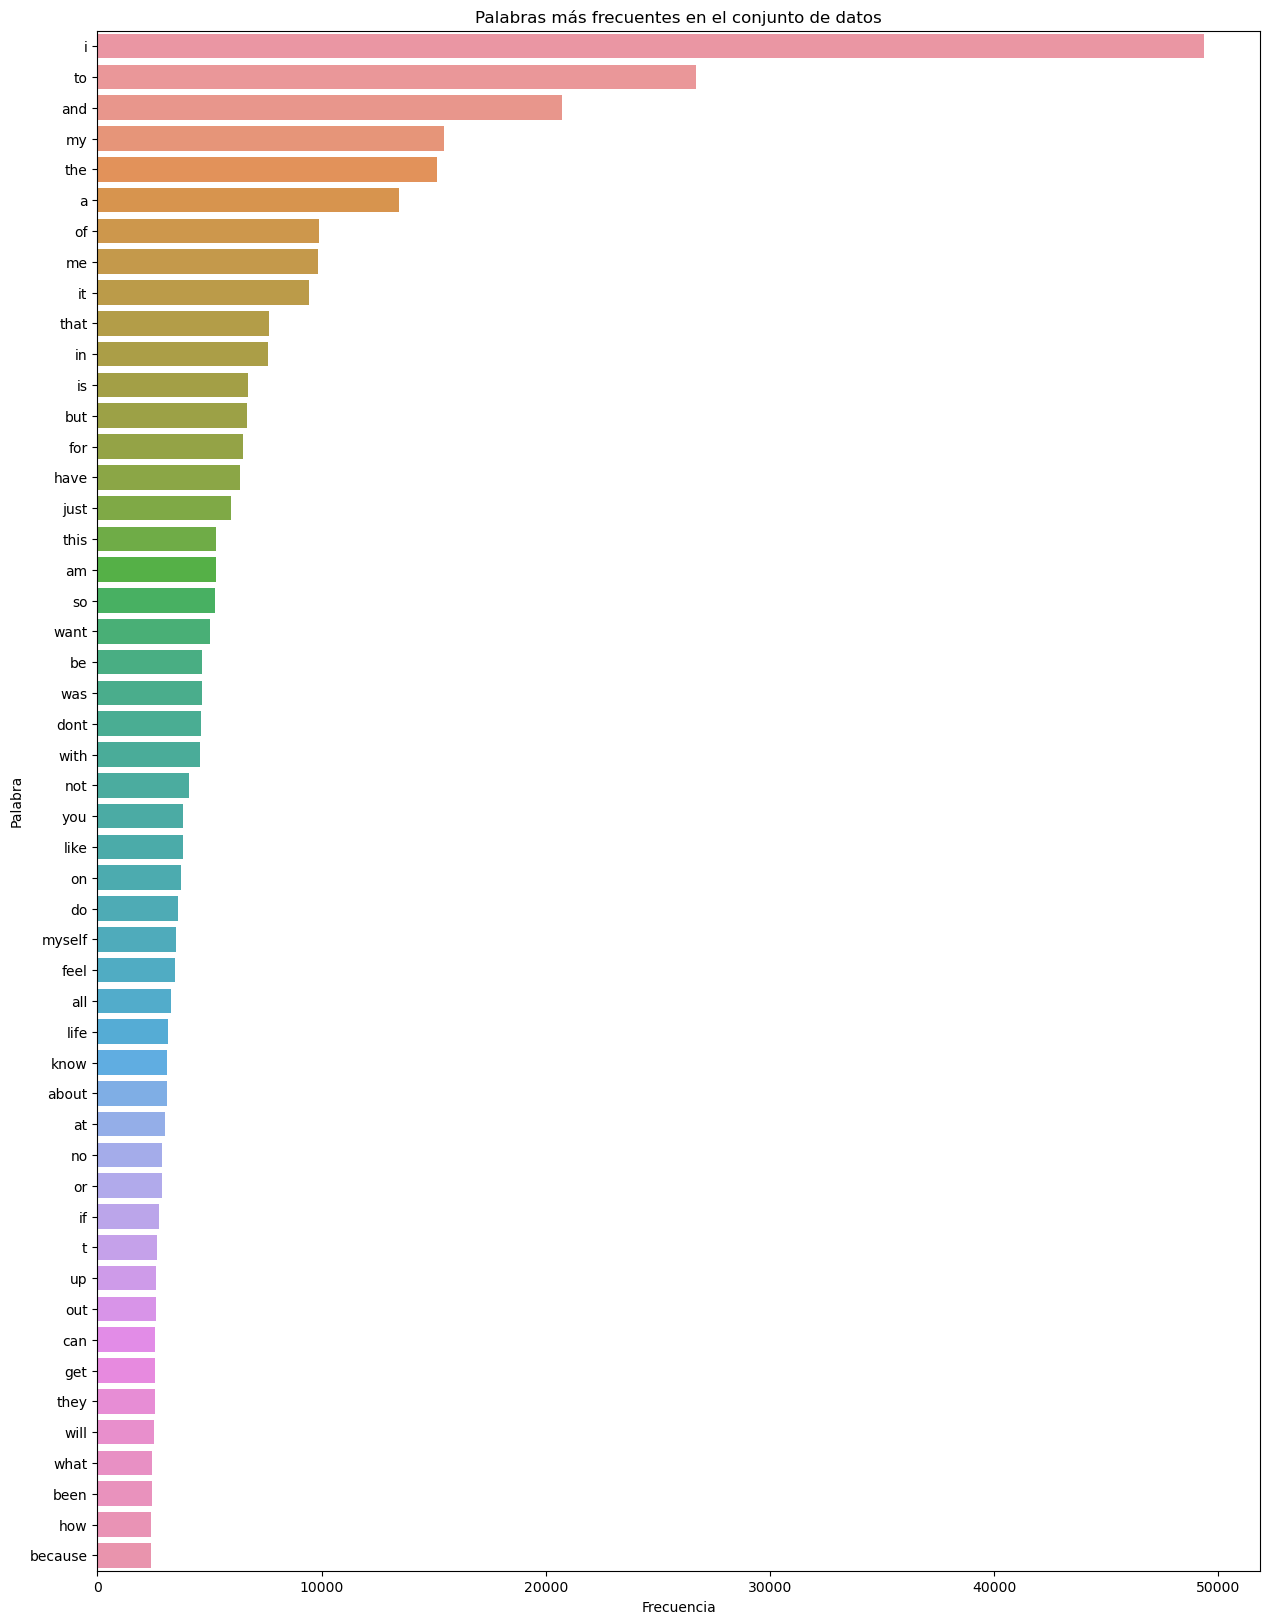

In [23]:
import seaborn as sns
from collections import Counter

# Obtener una lista de todas las palabras en el conjunto de datos
all_words = [word for tokens in tokenized_tweet for word in tokens]

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words)

# Crear un DataFrame con las frecuencias de palabras
word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Crear un gráfico de barras para las 50 palabras más frecuentes
plt.figure(figsize=(15, 20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más frecuentes en el conjunto de datos')
plt.show()

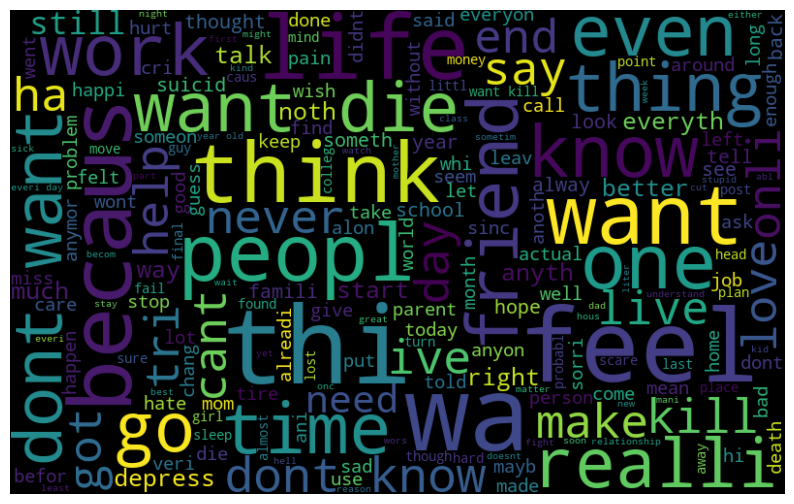

In [21]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label si:

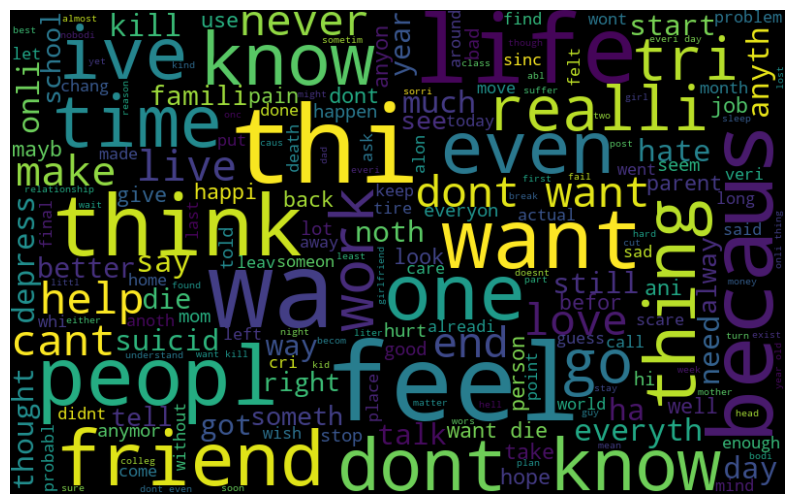

In [22]:
#Suicide
negative_words = ' '.join([text for text in train['tidy_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label no:

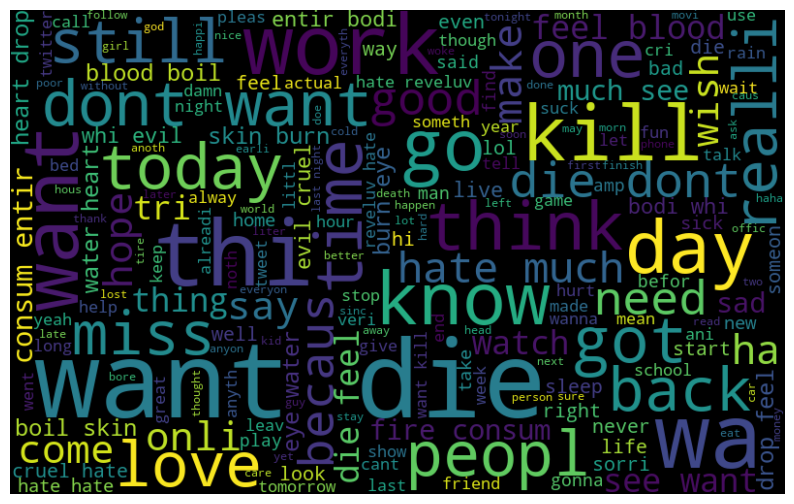

In [23]:
#Non-suicide
normal_words =' '.join([text for text in train['tidy_tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Vectorizacin**

* BOW (Bag of Words)

In [24]:
#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['tidy_tweet'])
bow.shape
# bow[:5]

(9206, 7400)

* TF-IDF (Term Frecuency, Inverse Document Frecuency)

In [25]:
#Tf-IDF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tidy_tweet'])
tfidf_matrix.shape

(9206, 7400)

* Word-Embbedings

In [26]:
#Word embbeding
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tidy_tweet']), epochs=20)

(5813944, 7066000)

Ahora que tenemos entrenado el modelo de word-embbeding podemos ver por ejemplo para una palabra cúales son las que se parecen entre sí.

In [27]:
print(model_w2v.wv.most_similar(positive="die"))

[('want', 0.6421195268630981), ('notexist', 0.5926617383956909), ('orbit', 0.5790094137191772), ('nevi', 0.5764435529708862), ('stan', 0.5632888674736023), ('yuta', 0.563014566898346), ('ene', 0.5608684420585632), ('schlanni', 0.5600650906562805), ('weeb', 0.5483014583587646), ('reveluv', 0.5426144599914551)]


In [28]:
print(model_w2v.wv.most_similar(positive="suicid"))

[('darkest', 0.5498877763748169), ('ideat', 0.5497661828994751), ('myselfmi', 0.5475659966468811), ('overcam', 0.5408164858818054), ('comit', 0.5351689457893372), ('yesterdaymi', 0.5324521064758301), ('depressionanxieti', 0.5261185765266418), ('indulg', 0.5237507224082947), ('thisiv', 0.5216400027275085), ('involuntarili', 0.5193850994110107)]


In [29]:
model_w2v.wv.get_vector('suicid')

array([ 2.13669792e-01, -1.47652954e-01,  1.05777815e-01,  4.06371891e-01,
       -2.06385925e-01, -2.52392232e-01,  1.67771935e-01, -3.29887807e-01,
        4.66966629e-02,  2.63543516e-01, -2.04128072e-01, -9.79038775e-02,
        8.81287176e-03, -1.72190532e-01,  1.96952969e-01,  4.49478626e-02,
        3.98724705e-01, -2.86443025e-01, -2.64922678e-01, -1.00289367e-01,
       -5.46288490e-01, -1.71917886e-01, -4.69238877e-01,  3.57745439e-01,
       -1.27978176e-01,  2.12306485e-01, -3.49818051e-01,  1.16883367e-01,
        3.01409941e-02,  6.74375193e-03, -1.59462318e-01, -1.93912029e-01,
       -4.47187930e-01,  6.04614131e-02, -9.86305177e-02, -1.39016569e-01,
        5.60925938e-02, -1.57095641e-01,  2.45358422e-01,  8.06535929e-02,
       -2.56347269e-01, -8.57622325e-02,  8.32050890e-02, -3.91637944e-02,
       -1.92866221e-01,  5.26989996e-01,  2.88126916e-01,  1.95913777e-01,
        1.01522587e-01,  1.00118637e-01, -3.14180404e-02, -2.92738855e-01,
        1.22350171e-01, -

No obstante, si queremos utilizar el modelo entrenado para predecir las etiquetas lo tenemos qu evectorizar de la siguiente manera:

In [30]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec

In [31]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9206, 200)

In [32]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

labeled_tweets[:6]

[TaggedDocument(words=['life', 'meaningless', 'want', 'end', 'life', 'badli', 'life', 'complet', 'empti', 'dont', 'want', 'creat', 'mean', 'creat', 'mean', 'pain', 'long', 'hold', 'back', 'urg', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposit', 'way', 'stop', 'feel', 'jealou', 'tragic', 'charact', 'like', 'gomer', 'pile', 'swift', 'end', 'abl', 'bring', 'live'], tags=['tweet_0']),
 TaggedDocument(words=['mutter', 'wanna', 'die', 'daili', 'month', 'feel', 'worthless', 'soulmat', 'cant', 'live', 'thi', 'horribl', 'world', 'without', 'lone', 'wish', 'could', 'turn', 'part', 'brain', 'feel'], tags=['tweet_1']),
 TaggedDocument(words=['work', 'slave', 'realli', 'feel', 'like', 'onli', 'purpos', 'life', 'make', 'higher', 'man', 'money', 'parent', 'forc', 'colleg', 'much', 'plate', 'owe', 'lot', 'money', 'know', 'thi', 'easi', 'way', 'realli', 'tire', 'issu', 'top', 'deal', 'tension', 'america', 'well', 'want', 'rest'], tags=['tweet_2']),
 TaggedDocument(words=['someth', 'oc

In [33]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(train['tidy_tweet']), epochs=15)

docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(train)):
    docvec_arrays[i, :] = model_d2v.dv[i].reshape((1, 200))

docvec_df = pd.DataFrame(docvec_arrays)
print(docvec_df)
docvec_df.shape

100%|██████████| 9206/9206 [00:00<?, ?it/s]


           0         1         2         3         4         5         6    \
0     0.583550  0.114086  0.413993  0.195024 -0.499652 -0.588974 -0.868089   
1    -0.260841 -0.087564  0.068422  0.452534 -0.315250 -0.005151 -0.556122   
2     0.714017  0.818760  0.376811 -0.140955  0.160750 -0.047548  0.033169   
3    -0.108140  0.059706  0.704854  0.297199  0.470463  0.206698  0.953616   
4    -0.087728  0.356032  0.057610  0.360066 -0.220105  0.305080  0.174875   
...        ...       ...       ...       ...       ...       ...       ...   
9201 -0.157514  0.179174  0.210273  0.151061 -0.220217 -0.113597  0.036884   
9202 -0.178759 -0.073686  0.109306  0.391197 -0.601314  0.113056  0.351160   
9203  0.434548  0.071335  0.124975  0.120683 -0.082310 -0.333920 -0.057047   
9204  0.045994  0.014435  0.231564  0.211954  0.065648  0.023074  0.123982   
9205  0.075966  0.129781  0.136492  0.053222 -0.015461 -0.000591  0.063557   

           7         8         9    ...       190       191    

(9206, 200)

**Clustering**

Vamos a aplicar clustering con KMeans para los 3 diferntes vectores que tenemos. Además, vamos a comparar el valor que da con una librería a hacer un KMeans implementado por nosotros.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

* KMeans con scikit-learn:

BOW

In [62]:
train_bow = bow

# train_bow = bow[:7365,0:1]
# test_bow = bow[7365:,1:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow.toarray(), train['label'],
                                                          random_state=42,
                                                          test_size=0.2)
# xtrain_bow, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
train_bow.shape


lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)

print("Puntuación F-Score para bow con lr",f1_score(yvalid, prediction_int)) # calculating f1 score


Puntuación F-Score para bow con lr 0.8722063037249282


TF-IDF

In [63]:
# TI-IDF Features
train_tfidf = tfidf_matrix

xtrain_tfidf = train_tfidf[ytrain.index].toarray()
xvalid_tfidf = train_tfidf[yvalid.index].toarray()

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)

print("Puntuación F-Score para tf-idf con lr", f1_score(yvalid, prediction_int))


Puntuación F-Score para tf-idf con lr 0.85


Word-Embbeding

In [64]:
# Word2vec Features
train_w2v = wordvec_df

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

xtrain_w2v.shape

lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)
print("Puntuación F-Score para word-embedding con lr", f1_score(yvalid, prediction_int))

Puntuación F-Score para word-embedding con lr 0.8061696658097686


* KMeans implementado por nosotros:

In [65]:
from kMeans import *
from kMeans_cuda import *

BOW

In [66]:
# Convierte la matriz a un formato adecuado para tu KMeans
bow_array = bow.toarray()
print(bow_array.shape)

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, initialisation_method='2k', iter_max=100, p_value=2)
algoritmo.ajustar(instances=bow_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_bow = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_bow)

(9206, 7400)
Algoritmo inicializando 2k clusters

Iteracion 0
Número de instancias para cluster  0 	 8534
Número de instancias para cluster  1 	 147
Número de instancias para cluster  2 	 329
Número de instancias para cluster  3 	 196

Iteracion 1
Número de instancias para cluster  0 	 7659
Número de instancias para cluster  1 	 136
Número de instancias para cluster  2 	 926
Número de instancias para cluster  3 	 485

Iteracion 2
Número de instancias para cluster  0 	 7443
Número de instancias para cluster  1 	 105
Número de instancias para cluster  2 	 1163
Número de instancias para cluster  3 	 495

Iteracion 3
Número de instancias para cluster  0 	 7302
Número de instancias para cluster  1 	 86
Número de instancias para cluster  2 	 1323
Número de instancias para cluster  3 	 495

Iteracion 4
Número de instancias para cluster  0 	 7244
Número de instancias para cluster  1 	 65
Número de instancias para cluster  2 	 1391
Número de instancias para cluster  3 	 506

Iteracion 5
Número 

In [68]:
algoritmo.dibujar_dendrograma()




 Links 



[[5.13300000e+03 8.94500000e+03 0.00000000e+00 2.00000000e+00]
 [1.09600000e+03 1.11800000e+03 0.00000000e+00 2.00000000e+00]
 [3.33600000e+03 9.20700000e+03 0.00000000e+00 3.00000000e+00]
 ...
 [2.63700000e+03 1.84070000e+04 7.27873615e+01 9.20400000e+03]
 [2.82900000e+03 1.84080000e+04 7.28971879e+01 9.20500000e+03]
 [6.70300000e+03 1.84090000e+04 1.05252078e+02 9.20600000e+03]]


TF-IDF

In [45]:
# Convierte la matriz TF-IDF a un formato adecuado para tu KMeans
tfidf_array = tfidf_matrix.toarray()

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, iter_max=10, p_value=2)
algoritmo.ajustar(instances=tfidf_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_tfidf = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_tfidf)

AttributeError: 'KMeans_Clustering_CUDA' object has no attribute 'labels'

Word-Embbedding

In [44]:
# Convierte la matriz a un formato adecuado para tu KMeans
wd_array = train_w2v
print(wd_array)

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, iter_max=20, p_value=2)
algoritmo.ajustar(wd_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_wd = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_wd)

           0         1         2         3         4         5         6    \
0     0.002489 -0.070757  0.124138 -0.030376 -0.219605  0.051768 -0.006725   
1    -0.085125 -0.023113  0.173330  0.037331 -0.325786  0.064258 -0.099543   
2    -0.025177 -0.127960  0.086415 -0.107094 -0.232885  0.040117 -0.068471   
3    -0.025878 -0.029130  0.047491 -0.038148 -0.183146  0.093262 -0.074578   
4    -0.166873 -0.115838  0.013070 -0.040850 -0.259445 -0.065643 -0.086593   
...        ...       ...       ...       ...       ...       ...       ...   
9201 -0.214574 -0.155063  0.229787  0.092948  0.116484  0.089728  0.101317   
9202  0.008050  0.028993  0.022010 -0.073466 -0.102284  0.015974 -0.021707   
9203  0.131578  0.020637  0.089176  0.006527 -0.265493  0.228489  0.108996   
9204 -0.027859  0.016612  0.062171 -0.011612 -0.254633  0.114340 -0.244092   
9205 -0.147770 -0.136447  0.074736 -0.106287 -0.186385 -0.006478 -0.194031   

           7         8         9    ...       190       191    

AttributeError: 'KMeans_Clustering_CUDA' object has no attribute 'labels'

* Representación:

Para hacenos una idea de como se distribuyen los puntos en el espacio, podemos usar PCA.

In [1]:
from sklearn.decomposition import PCA

print('Dim originally: ',xtrain_tfidf.shape)
# Reducir las dimensiones para visualizarlas: PCA
pca = PCA(n_components=200)
pca.fit(xtrain_tfidf)
# Cambio de base a dos dimensiones PCA
X_train_PCAspace = pca.transform(xtrain_tfidf)
print('Dim after PCA: ',X_train_PCAspace.shape)

NameError: name 'xtrain_tfidf' is not defined

* Para saber la tasa de error podemos usar la matriz de confusión y con ello calcular la tasa de error:

In [ ]:
# Dibujar sólo unas pocas instancias
samples = 300
# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(X_train_PCAspace[:samples, 0], X_train_PCAspace[:samples, 1],
                 cmap=plt.get_cmap('nipy_spectral', 10), c=predicted_labels_KM_tfidf[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(X_train_PCAspace[i, 0], X_train_PCAspace[i, 1], y_train[i])
plt.title('Clustering en el espacio de PCA')

**Evaluación del modelo**

Para hacernos una idea de la bonanza del modelo, debemos usar métricas como F-Score, Precision, Recall. Además, métricas como la silueta o Kaminski nos pueden dar una idea de la solapación existente.

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_bow)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_bow)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_bow)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con BOW:", f_score)
print("Precision nuestro KMeans con BOW:", precision)
print("Recall nuestro KMeans con BOW:", recall)

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_tfidf)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con tf-idf:", f_score)
print("Precision nuestro KMeans con tf-idf:", precision)
print("Recall nuestro KMeans con tf-idf:", recall)

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_wd)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_wd)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_wd)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con Word-Embbeding:", f_score)
print("Precision nuestro KMeans con Word-Embbeding:", precision)
print("Recall nuestro KMeans con Word-Embbeding:", recall)

**Clasificación de nuevas instancias.**

In [ ]:
from clasificarNuevaInstancia import preproceso


nuevos_mensajes = ["Este es un mensaje de prueba", "Otro mensaje para probar", "Más mensajes"]
opcion = 'tf-idf'

nuevoArray = preproceso(nuevos_mensajes,opcion)

modelo = KMeans_Clustering_CUDA()

modelo.cargar_modelo_y_asignar_clusters(nuevoArray)